In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np

87 classes with 3219 images in total


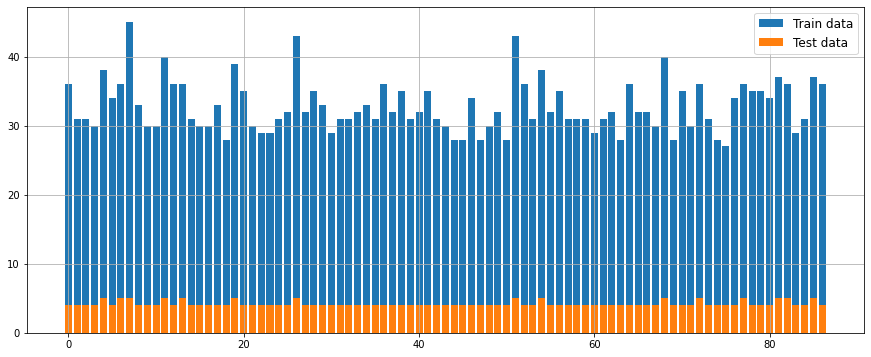

In [2]:
CLASSES, gems = [], [] # names of classes, count of images for each class

for root, dirs, files in os.walk('./archive'):
    f = os.path.basename(root)    # get class name - Amethyst, Onyx, etc    
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) # add folder name
            
gems_count = len(CLASSES) # 87 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

f, ax = plt.subplots(figsize=(15,6))
if(gems[0])<10:
    plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
else:
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
    plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
ax.grid()
ax.legend(fontsize = 12);

In [3]:
img_w, img_h = 220, 220    # width and height of image
train_dir = './archive/train/'

In [4]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Amethyst, Onyx, etc       
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [5]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach CLASSES
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [6]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (2856, 330, 330, 3)
Shape of train labels: (2856,)


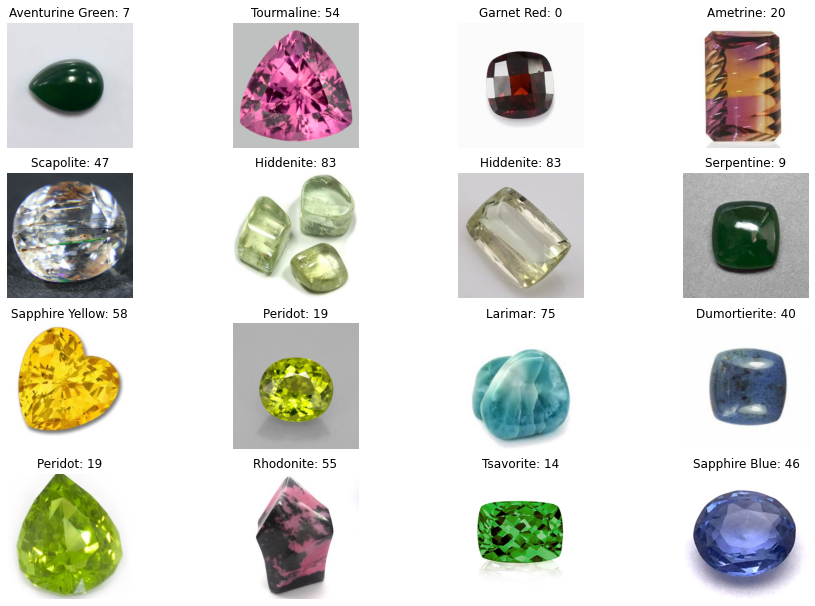

In [7]:
dim = 4 #you can change it;  4x4 dimension flat plot

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

In [8]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [9]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
            
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)

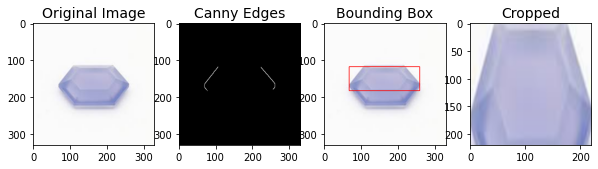

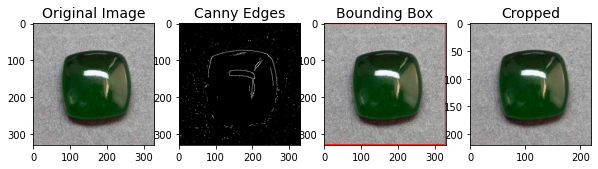

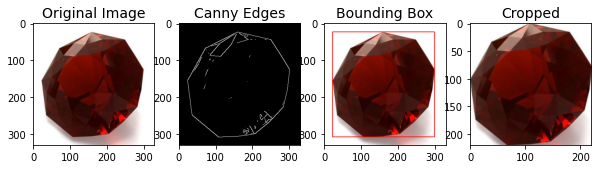

In [10]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

## 8. Replace train images with cropped images

- Create function which calls edge_and_cut and replaces Train_Imgs numpy array with array of cropped images. Don't forget that images that cannot be cropped will be replced with originals;

- Make sure the shape of final array is the same: NUMBER OF IMAGES x img_w x img_h x 3 (CHANNELS):

In [11]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [12]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (2856, 220, 220, 3) 


## 9. Split data into train and validation sets

- use sklearn to split Train_Imgs, Train_Lbls into train (80%) and validation (20%) sets. Important!

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (2284, 220, 220, 3), y_train: (2284,) 
Shape of X_val: (572, 220, 220, 3), y_val: (572,) 


# III. Prepare for model creation

## 1. Check devices

#### 텐서 플로우를 사용하여 어떤 장치가 Kaggle 플랫폼을 사용하는지 확인한다.

- XLA_CPU 디바이스: CPU
- XLA_GPU 장치: Tesla P100-PCie-16GB(컴퓨팅을 가속화하려면 GPU 모드를 사용합니다.)
#### XLA는 가속 선형 대수를 나타냅니다. Tensorflow의 비교적 최적화된 컴파일러로 ML 모델의 속도를 더욱 높일 수 있습니다.

#### GPU 모드를 사용하여 이 노트북을 실행합니다 : 
for example, using image size 190 x 190 and basic architecture of CNN mentioned above every epoch on CPU takes ~3 minutes, on GPU ~ 15 sec.

In [14]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11613961624599101267
]


## Import keras
Keras is an open-source neural-network library written in Python which is capable of running on top of TensorFlow. From Keras needed:

- models : type of models, import only Sequential
- layers : 모델에 해당하는 레이어: 단순한 레이어는 Conv2D, MaxPooling2D 및 AveragePooling2D만 사용
- optimizers : 역전파 알고리즘 포함
- ImageDataGenerator : 이미지 증강용(각 클래스의 샘플이 그리 많지 않을때)


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

# Build a simple CNN
CNN(Convolutional Neural Network 또는 ConvNet)은 시각 이미지 분석에 일반적으로 적용되는 심층 신경 네트워크의 한 종류이다. 다음은 CNN의 가장 간단한 예이다.

# I. Provide Hyperparameters
하이퍼 파라미터는 훈련 전에 설정된다. neural network 구조와 훈련 방법을 결정하는 변수를 나타낸다.

## 1. Parameters for layers
- 컨볼루션 레이어 필터 크기(필터). 필터 수는 데이터 세트의 복잡성과 신경 네트워크의 깊이에 따라 달라져야 한다.
- 세 개의 레이어에 대한 공통 설정은 [32, 64, 128].
- kernel_size = number of filters 전체 이미지가 스캔될 때 한번에 이동하는 픽셀 창(3 X 3)
- 만약 이미지가 128×128보다 작으면 1×1의 작은 필터로 작업.
- 이미지의 폭과 높이는 미리 제공됨. 2D 컨볼루션 레이어는 3차원 입력(일반적으로 3개의 컬러 채널이 있는 이미지)을 취함.
- max_pool = max pooling은 2D 입력 공간에 걸쳐 움직이는 창을 적용한 것으로, 이 창에서 최대값은 출력 2x2.


In [17]:
filters = 32      # the dimensionality of the output space
kernel_size = 3   # length of the 2D convolution window
max_pool = 2      # size of the max pooling windows

## 2. Parameters to fit the model

- epoch는 알고리즘이 전체 데이터 집합을 보는 횟수를 나타냄. 데이터 집합의 모든 샘플을 알고리즘에서 볼 때마다 하나의 에포크가 완료됨
- 한 에포크가 완료되는 것은 너무 커서 한 번에 메모리에 전달할 수 없기 때문에 그것을 몇 개의 작은 배치로 나눔. 배치 크기는 항상 2의 배율
- 에포크당 반복 횟수 = 패스 수, 각 패스는 배치 크기를 사용.

따라서 교육 샘플이 최대 2,200(80%)이고 배치 크기가 32인 경우 1개 에포크를 완료하는 데 70회까지 반복해야 함

In [18]:
EPOCHS = 70                                  # while testing you can change it
batch_size = 32                              # number of training samples using in each mini batch during GD (gradient descent) 
iter_per_epoch = len(X_train) // batch_size  # each sample will be passed [iter_per_epoch] times during training
val_per_epoch = len(X_val) // batch_size     # each sample will be passed [val_per_epoch] times during validation

# Provide a model
## 1. Architect a model
순차 모델은 레이어의 선형 스택입니다.
- I use a kind of VGG network architecture:
Layers
1	Conv2D 32 -> Pool
2	Conv2D 64 -> Pool
3	Conv2D 128 -> Pool
4	Conv2D 128 -> Pool
5	Conv2D 128 -> Pool
6	FLAT
7	Drop
8	Dense 512
9	Dense len(CLASSES)

#### ADD 5 'blocks':
- 위에 언급된 하이퍼마미터가 있는 Conv2D: Conv2D(커널_size, (filters, filters), input_shape=(img_w, img_h, 3)) 및 각 레이어에 대한 활성화 함수(ReLU): 활성화('relu')
- 들어오는 특성의 공간 크기를 줄이기 위한 MaxPooling 2D 레이어, 2D input space: MaxPooling 2D(pool_size =(max_pool, max_pool)
- 커널 크기를 32 -> 64 -> 128 -> 128 -> 128로 늘리기 위해 동일한 작업을 수행.
#### 2. 입력을 지연. 다차원 벡터를 단일 차원 벡터로 변환: Flatten()
#### 3. 입력의 특정 부분을 임의로 0으로 설정하고 과적합을 줄이는 데 도움이 되는 드롭아웃 계층 추가: Dropout(0.5)
#### 4. 512개 노드로 완전 연결된 레이어 추가 및 활성화 함수 relu: ense(512), Activation('relu')
#### 5. 원석의 클래스 수를 지정하는 마지막 완전히 연결된 레이어를 제공: 87. 소프트맥스 활성화 함수는 잠재적 결과 목록의 확률 분포를 나타내는 벡터를 출력: Dense(87, activation='softmax')
</br>
- Print the summary of the model.

In [19]:
model = Sequential()

# first layer
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features

# second layer
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(MaxPooling2D((max_pool, max_pool))) 

# third layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

# fourth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 

# fifth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))                                             # 512
model.add(Dense(87, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

모델 요약에는 교육해야 할 매개 변수가 2M 이상이고 서로 다른 계층에 대한 정보가 있음을 보여 줍니다.

## Compile a model

- 